In [52]:
import numpy as np
import h5py,time, matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, minimize
from drift.core import manager
import corrcal2
import sys
sys.path.insert(0,'/home/zahra/PIPELINE')
from log_red_cal_new import Visibilities_grid, Bls_counts, colour_scatterplot, Scatterplot
from decimal import Decimal
from operator import add,sub
from scipy.optimize import LinearConstraint, BFGS, Bounds
import scipy as sp


In [53]:
#ts_2=h5py.File('/media/zahra/DATA/example_5by5_lmax_200_no_scatter/draco_synthesis_no_fluc/maps/tstream_2.h5','r')
#ag_2=h5py.File('/media/zahra/DATA/example_5by5_lmax_200_no_scatter/draco_synthesis_no_fluc/rand_gains/amp_phase/app_gain_2.h5','r')
#rg_2=h5py.File('/media/zahra/DATA/example_5by5_lmax_200_no_scatter/draco_synthesis_no_fluc/rand_gains/sig_2.h5','r')
#gn_2=h5py.File('/media/zahra/DATA/example_5by5_lmax_200_no_scatter/draco_synthesis_no_fluc/rand_gains/ts_final/app_gain_noise_2.h5','r')



ts_2=h5py.File('/home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/draco_synthesis_no_fluc/maps/tstream_2.h5','r')
ag_2=h5py.File('/home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/draco_synthesis_no_fluc/rand_gains/amp_phase/app_gain_2.h5','r')
rg_2=h5py.File('/home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/draco_synthesis_no_fluc/rand_gains/sig_2.h5','r')
gn_2=h5py.File('/home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/draco_synthesis_no_fluc/rand_gains/ts_final/app_gain_noise_2.h5','r')


#ts_2=h5py.File('/media/zahra/DATA/5by5_dishvar_trial2/draco_synthesis/maps/tstream_2.h5','r')
#ag_2=h5py.File('/media/zahra/DATA/5by5_dishvar_trial2/draco_synthesis/rand_gains/amp_phase/app_gain_2.h5','r')
#rg_2=h5py.File('/media/zahra/DATA/5by5_dishvar_trial2/draco_synthesis/rand_gains/sig_2.h5','r')

#gn_2=h5py.File('/media/zahra/DATA/5by5_dishvar_trial2/draco_synthesis/rand_gains/ts_final/app_gain_noise_2.h5','r')

#ts_2=h5py.File('/home/zahra/PIPELINE/5by5_dishvar_pt1/draco_synthesis/maps/tstream_2.h5','r')
#ag_2=h5py.File('/home/zahra/PIPELINE/5by5_dishvar_pt1/draco_synthesis/rand_gains/amp_phase/app_gain_2.h5','r')
#rg_2=h5py.File('/home/zahra/PIPELINE/5by5_dishvar_pt1/draco_synthesis/rand_gains/sig_2.h5','r')

#gn_2=h5py.File('/home/zahra/PIPELINE/5by5_dishvar_pt1/draco_synthesis/rand_gains/ts_final/app_gain_noise_2.h5','r')


In [54]:
#m = manager.ProductManager.from_config('/media/zahra/DATA/example_5by5_lmax_200_no_scatter/prod_params_custom.yaml')
m=manager.ProductManager.from_config('/home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/prod_params_custom.yaml')
t=m.telescope
x=t.feedpositions[:,0] #these are x and y positions not x and y polarizations
y=t.feedpositions[:,1]


#klobj=m.kltransforms['kl']

time_channel=400
Ndish=25
correlation_arr,sum_counts,corr_counts=Bls_counts(m)

Nbls,_=correlation_arr.shape


Product directory: /home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/bt_matrices


In [55]:
sum_full_real = np.load('sum_full_real_5by5.npy')
sum_full_imag = np.load('sum_full_imag_5by5.npy')

In [56]:
sum_real_diag=np.diag(sum_full_real)
sum_imag_diag=np.diag(sum_full_imag)
real_sig_condensed_1=sum_real_diag[3:163][0::4]
real_sig_condensed_2=sum_real_diag[166:326][0::4]

imag_sig_condensed_1=sum_imag_diag[3:163][0::4]
imag_sig_condensed_2=sum_real_diag[166:326][0::4]


real_signal_expanded_1=np.repeat(real_sig_condensed_1,corr_counts)
real_signal_expanded_2=np.repeat(real_sig_condensed_2,corr_counts)

imag_signal_expanded_1=np.repeat(imag_sig_condensed_1,corr_counts)
imag_signal_expanded_2=np.repeat(imag_sig_condensed_2,corr_counts)

real_signal=np.append(real_signal_expanded_1,real_signal_expanded_2)
imag_signal=np.append(imag_signal_expanded_1,imag_signal_expanded_2)
vecs=np.vstack([real_signal,imag_signal])

#print vecs.shape
#print real_sig_condensed_1.shape

In [57]:
sum_full = np.vectorize(complex)(sum_full_real, sum_full_imag)[3:163,3:163 ][0::4, 0::4]

#sum_full = np.array([sum_full_real, sum_full_imag], dtype=complex)

eigs_val, eigs_vec=np.linalg.eig(sum_full)

eig_min=2
eig_max=12

eigs_val_lmin = eigs_val[eig_min:eig_max]
eigs_vec_lmin=eigs_vec[eig_min:eig_max, eig_min:eig_max]

nvec=len(eigs_val_lmin)
print nvec


Q=eigs_vec_lmin*eigs_val_lmin**0.5

QtQ=np.matmul(Q.T, Q)
QtQ=QtQ.flatten()

print len(QtQ)
QtQ_full=np.zeros(2*len(QtQ))
QtQ_full[0::2]=QtQ.real
QtQ_full[1::2]=QtQ.imag
QtQ_full=QtQ_full.reshape(nvec,-1)
print QtQ_full.shape

QtQ_full_row, QtQ_full_column = QtQ_full.shape
print QtQ_full_column

vecs = np.repeat(QtQ_full, 2*Nbls/QtQ_full_column, axis=1)
#vecs = np.repeat(QtQ_full, 40, axis=1)

print vecs.shape

#vecs_1 = np.repeat(vecs[0], Nbls)
#vecs_2=np.repeat(vecs[1], Nbls)
#vecs=np.vstack([vecs_1, vecs_2])

#vecs_rep=np.repeat(vecs, Nbls)
#vecs=vecs_rep.reshape(nvec, 2*Nbls)
#print vecs.shape
#sig=m.beamtransfer.project_matrix_sky_to_telescope(0,klobj.foreground())[0,:,0,:]
#sig=np.abs(sig)
#print sig[sig>0].shape

#vecs=np.matmul(Q.T, Q)
#vecs_1=np.repeat(np.abs(vecs[0]),corr_counts)
#vecs_2=np.repeat(vecs[1].flatten(),corr_counts)
#vecs=np.vstack([vecs_1,vecs_2])

10
100
(10, 20)
20
(10, 600)


In [ ]:
def get_redblock_svd(redblock_cov_matrix_eig,threshold):
    """
    This fuction reduce the size of redundant block covariance matrix by select the only eigenmodes
    with magnitude above expected signal threshold and set to zero the rest of modes.
    
     Parameters
    ----------
    redblock_cov_matrix_eig: array(NFREQS,NBLOCKS,NEIGVALS,NEIGVECS) dtype: complex
        Arrays of NFREQS, NBLOCK of redundant blocks, NEIGVALS & NEIGVECS for each redundant block.
    threshold              : float
			    Threshold of the eigenmode that will be selected.
   
         
         
    
    
    Returns
    -------
    R_all_freq : (NFREQS,NBLOCKS,2*NEIGVALS,2*NEIGVECS) array
        Array for all frequency with redundant  block reduced in size by selecting nmax of largest
	eigenmodes. The real and imaginary has be separated, hence 2 times the size of eigmodes.
    edges: array 
	 Array containing the index of the block edges.
    """


    
    RR= redblock_cov_matrix_eig
    nblock=RR[0].shape[0]

    edges=np.zeros(nblock+1,dtype='int')
    R_all_freq=[]
    for nu_i in range(len(RR)):
    	nmax=0
    	thresh=threshold
    	nvis=0
    	for i in range(nblock):
        	myeig=qq[nu_i][i][0]
        	nkept=np.sum(myeig>thresh*myeig.max())
        	nvis=nvis+myeig.size
        	edges[i+1]=edges[i]+myeig.size
        	if nkept>nmax:
            		nmax=nkept
    	print 'total number of visibilities is ' + repr(nvis) + ' with ' + repr(nmax) + ' kept eigenvalues at max.'
    	# computeting R = vl^1/2, l_above_threshold
    	R=np.zeros([2*nvis,nmax*2])
    
   	myeig_vec =[]
    	for i in range(nblock):
        	myeig=np.real(RR[nu_i][i][0])
        	myvecs=np.real(RR[nu_i][i][1])
        	ind=myeig>thresh*myeig.max() # picking up an index
        	#print 'index max eiegen', ind
        	myeig_use=myeig[ind] # pict max eigenvalue
        	#print myeig_use.shape
        	myvecs_use=myvecs[:,ind] # pick  corresponding max eigenvec
        	#print myvecs_use.shape
        	for j in range(len(myeig_use)):
            		myvecs_use[:,j]= myvecs_use[:,j]*np.sqrt(myeig_use[j])
            
            		R[2*edges[i]:2*edges[i+1]:2,2*j]=  np.column_stack(myvecs_use[:,j])
            		R[(2*edges[i]+1):2*edges[i+1]:2,2*j+1]= np.column_stack(myvecs_use[:,j])

	R_all_freq.append(R)


    return R_all_freq, edges

In [126]:
nvis=0
nmax=0
edges=np.zeros(nblock+1,dtype='int')
R_all_freq=[]
myeig_vec =[]
for i in range(nblock):
    myeig=eigs_val.real[i]
    nkept=np.sum(myeig>thresh*myeig.max())
    nvis=nvis+myeig.size
    edges[i+1]=edges[i]+myeig.size
    if nkept>nmax:
            nmax=nkept
    #print 'total number of visibilities is ' + repr(nvis) + ' with ' + repr(nmax) + ' kept eigenvalues at max.'
    R=np.zeros([2*nvis,nmax*2])
    
for i in range(nblock):
    print i
    myeig = eigs_val.real[i]
    myvecs = eigs_vec.real[i]
    ind = myeig > thresh*myeig.max()
    print ind
    myeig_use = myeig[ind]
    print myeig_use, 'my eig use'
    myvecs_use = myvecs[:,ind]
    print myvecs_use.shape
    print len(myeig_use), 'len myeig use'
    for j in range(len(myeig_use)):
        print j, 'j'
        myvecs_use[:,j]= myvecs_use[:,j]*np.sqrt(myeig_use[j])
        print myvecs_use.shape
        print np.column_stack(myvecs_use[:,j])
        R[2*edges[i]:2*edges[i+1]:2,2*j]=  np.column_stack(myvecs_use[:,j])
        R[(2*edges[i]+1):2*edges[i+1]:2,2*j+1]= np.column_stack(myvecs_use[:,j])

R_all_freq.append(R)

0
True
[4.25472709] my eig use
(40, 1)
1 len myeig use
0 j
(40, 1)
[[ 1.53739232e+00 -1.34211481e+00 -2.26734924e-01  1.22785414e-01
   4.98840941e-02 -1.41947395e-01  9.42111198e-03  1.44066352e-02
  -9.88169076e-04 -2.22269236e-03  9.62876535e-06  2.19948014e-03
  -1.85493880e-04 -1.06679987e-04  2.78611556e-04  4.66991948e-05
  -1.08813262e-05 -3.36928157e-05  9.78042051e-07  4.22136404e-06
  -7.39666000e-09 -4.93736417e-08 -7.88500301e-08  7.29625476e-10
  -1.81896998e-08 -5.69453420e-10  7.28105953e-10  8.10256642e-11
  -3.21568579e-11 -1.20466685e-12 -1.58677351e-12  8.37021200e-14
   1.20359370e-14  2.80827731e-14  3.22215590e-15  4.14413879e-16
   7.77649405e-15  1.29171953e-15 -2.48738971e-15 -8.14941485e-16]]


ValueError: could not broadcast input array from shape (40) into shape (1)

In [100]:
print eigs_val.real.size
print eigs_vec.real.shape
print np.vstack((eigs_val.real, eigs_vec.real)).shape


        

40
(40, 40)
(41, 40)


ValueError: could not broadcast input array from shape (40) into shape (20)

In [73]:
thresh= 1.e-8
np.sum(eigs_val>thresh*eigs_val.max())

R=np.zeros([600,24])

12

In [58]:

#m=manager.ProductManager.from_config('/home/zahra/PIPELINE/5by5_dishvar_pt1/prod_params_custom.yaml')

#m=manager.ProductManager.from_config('/home/zahra/PIPELINE/ex_3by3_dish_var/prod_params_custom.yaml')
#Scatterplot(m)


v1=np.zeros(2*Nbls)
v1[0::2]=1
v2=np.zeros(2*Nbls)
v2[1::2]=1
#vecs=1.e3*np.vstack([v1,v2])

lims=sum_counts
lims=np.append(0,sum_counts)
print lims

#lims=np.append(lims,lims)
#diag=sigma**2*np.ones(72)/1000


src=np.zeros(2*Nbls)
src=src.reshape([1,2*Nbls]) 
#src=1000*v1

ant1=correlation_arr[:,0].astype(int)
ant2=correlation_arr[:,1].astype(int)


[  0  20  40  56  72  87 102 114 126 138 150 160 170 179 188 196 204 212
 220 226 232 238 244 249 254 258 262 266 270 274 278 281 284 287 290 292
 294 296 298 299 300]


In [59]:
random_pt1=np.load('random_pt1.npy')
random_logcal=np.mean(np.load('/home/zahra/corrcal2/logcal_5by5_lownoise_nogainfluc_no_dish_scatter/gg_logcal_5by5_nogainfluc_Tsys_50_no_dish_scatter.npy'),axis=0)

random = np.zeros(Ndish*2)
random[0::2] = np.exp(random_logcal)
random[1::2] = random_pt1[:Ndish]
print random

[ 1.0011085   0.09092858  0.99954536  0.00390216  0.99984127 -0.04638916
  0.99970852 -0.01802413  0.99969696 -0.08949858  0.99974603 -0.08727972
  1.0007178   0.26302962  1.00002352 -0.0657686   0.99972801 -0.10670989
  1.00050338 -0.12960916  1.0003628  -0.0471747   0.99987714  0.19880598
  0.99964832 -0.10100869  1.00039811 -0.04706358  0.99998223 -0.03610565
  0.99992509  0.13763938  1.00031931  0.13101999  0.9999566   0.15201872
  0.99970171 -0.11209366  1.00004807  0.22243071  1.00045002 -0.15334061
  0.999485    0.11038711  0.99972486  0.06915971  0.99974354  0.02090274
  0.9997598  -0.17138845]


In [60]:
runs=100



def fit_gains(m,file_no_gain,gain_file, file_with_gain,file_gain_noise, time_channel,Tsys,ndays,random):
    
    gain_total=gain_file['gain'][0,:Ndish,time_channel]
    sim_gains=np.zeros(Ndish*2)
    sim_gains[0::2]=gain_total.real
    sim_gains[1::2]=gain_total.imag
    sim_gains_amp=sim_gains[0::2]
    sim_gains_phase=sim_gains[1::2]
    
    gg=np.zeros((runs,Ndish*2))
    for ind_run in range(runs):
        print ind_run
        arr=Visibilities_grid(m,file_no_gain,gain_file,file_with_gain,file_gain_noise,time_channel,Tsys,ndays)
        vis=arr[0][:,time_channel]
        sigma=arr[-1]
        diag=sigma**2*np.ones(2*Nbls)
        print (sigma)
        mat=corrcal2.sparse_2level(diag,vecs,src,2*lims) #init
        mult=random+1.

        gvec=np.array([])
        for i in range(len(sim_gains)):
            gvec=np.append(gvec,sim_gains[i]+random[i])
            #gvec=np.append(gvec,random[i])
            #gvec=np.append(gvec,sim_gains[i]*mult[i])


        data=np.zeros(2*vis.size)
        data[0::2]=vis.real
        data[1::2]=vis.imag
        fac=1.;
        normfac=1.
        asdf=fmin_cg(corrcal2.get_chisq,gvec*fac,corrcal2.get_gradient,(data,mat,ant1,ant2,fac,normfac))
        #asdf=fmin_cg(corrcal2.get_chisq_dense,gvec*fac,corrcal2.get_gradient_dense,(data,diag_mat,vecs_mat,ant1,ant2,fac,normfac))
        fit_gains_run=asdf/fac
        gg[ind_run,:]=fit_gains_run
    return gg, sim_gains_amp
 
gg_2, sim_gains_amp_2=fit_gains(m,ts_2,rg_2,ag_2, gn_2,time_channel,50,1,random_pt1)    

gg_2.shape


0
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 53461.342743
         Iterations: 19
         Function evaluations: 131
         Gradient evaluations: 119
1
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 52035.375283
         Iterations: 18
         Function evaluations: 88
         Gradient evaluations: 76
2
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 52417.158323
         Iterations: 17
         Function evaluations: 112
         Gradient evaluations: 100
3
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 52677.385365
         Iterations: 19
         Function evaluations: 94
         Gradient evaluations: 82
4
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 53531.680594
         Iterations: 19
         Function evaluations: 134
         Gradient evaluations: 121
5
(0.012207031

0.012207031977595827
         Current function value: 53865.699252
         Iterations: 19
         Function evaluations: 72
         Gradient evaluations: 61
32
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 53928.542890
         Iterations: 19
         Function evaluations: 62
         Gradient evaluations: 51
33
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 54159.057232
         Iterations: 19
         Function evaluations: 117
         Gradient evaluations: 105
34
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 53567.982901
         Iterations: 19
         Function evaluations: 108
         Gradient evaluations: 96
35
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 53746.112242
         Iterations: 19
         Function evaluations: 69
         Gradient evaluations: 58
36
(0.012207031977595827, 'sigma_gn')
0.0122070319

0.012207031977595827
         Current function value: 52796.494362
         Iterations: 17
         Function evaluations: 89
         Gradient evaluations: 77
63
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 52333.303245
         Iterations: 17
         Function evaluations: 64
         Gradient evaluations: 53
64
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 53508.670254
         Iterations: 19
         Function evaluations: 92
         Gradient evaluations: 80
65
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 53456.292294
         Iterations: 20
         Function evaluations: 122
         Gradient evaluations: 111
66
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 54150.006288
         Iterations: 20
         Function evaluations: 146
         Gradient evaluations: 134
67
(0.012207031977595827, 'sigma_gn')
0.012207031

0.012207031977595827
         Current function value: 53568.292586
         Iterations: 19
         Function evaluations: 74
         Gradient evaluations: 63
94
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 54026.993180
         Iterations: 20
         Function evaluations: 107
         Gradient evaluations: 96
95
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 54321.727837
         Iterations: 16
         Function evaluations: 68
         Gradient evaluations: 58
96
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 54667.113886
         Iterations: 19
         Function evaluations: 117
         Gradient evaluations: 105
97
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 51993.112848
         Iterations: 18
         Function evaluations: 97
         Gradient evaluations: 85
98
(0.012207031977595827, 'sigma_gn')
0.0122070319

(100, 50)

In [61]:
#np.save('gg_corrcal_100runs_Tsys_50_ndays_1_5by5_gain_fluc_pt1_gain_input_pt1',gg_2)
#np.save('sim_gains_amp_corrcal_100runs_Tsys_50_ndays_1_5by5_gain_fluc_pt1_gain_input_pt1',sim_gains_amp_2)


In [62]:

gg_corrcal, sim_gains_corrcal = gg_2, sim_gains_amp_2

def gains_mean_and_rel_err(gg,sim_gains_amp):
    gain_std=(np.std(gg,axis=0)/np.sqrt(runs)).flatten()
    gain_mean=np.mean(gg,axis=0).flatten() #shape is 98, we take every second one for amp so shape is 49
    rec_gains_mean_amp=gain_mean[0::2]
    rec_gains_std_amp=gain_std[0::2]
    rel_err_amp=np.abs(rec_gains_mean_amp-sim_gains_amp)/sim_gains_amp

    rel_err_amp_mean=np.mean(rel_err_amp)
    rel_err_amp_std=np.std(rel_err_amp,ddof=1)
    return rec_gains_mean_amp, rec_gains_std_amp, rel_err_amp, rel_err_amp_mean, rel_err_amp_std

rec_gains_mean_amp_2,_,rel_err_amp_2, rel_err_amp_mean_2 ,rel_err_amp_std_2 = gains_mean_and_rel_err(gg_corrcal, sim_gains_corrcal)

print rel_err_amp_std_2, rel_err_amp_mean_2

11.536396509666986 22.474479643427994


Text(0.5,1,'Averaged recovered gains vs simulated gains')

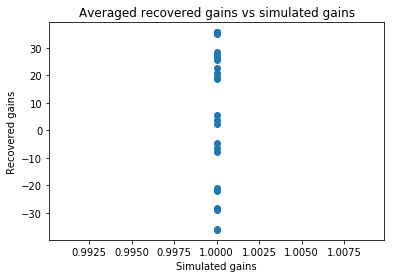

In [63]:
fig, ax = plt.subplots()

ax.scatter(sim_gains_amp_2, rec_gains_mean_amp_2)
#ax.plot(lims, lims,'g')
#plt.errorbar(x_true_real[:Ndish,time_channel],x_rec_real[:Ndish,time_channel],xerr=None,yerr=error[:Ndish],linestyle="None")
plt.xlabel('Simulated gains')
plt.ylabel('Recovered gains')
lim=.002
#plt.ylim(0.978,0.982)
plt.title('Averaged recovered gains vs simulated gains')
#plt.ylim(0.998,1.002)
#plt.savefig('avgd_recgains_vs_simgains_corrcal_5by5_nogainfluc_Tsys_50_no_dish_scatter_1e-4_initguess')


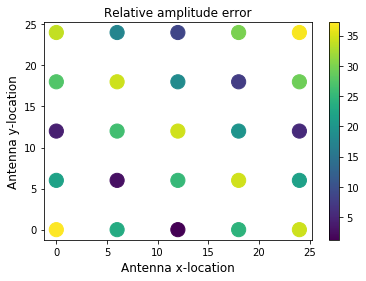

In [64]:
colour_scatterplot(m,rel_err_amp_2)

In [65]:
print rec_gains_mean_amp_2.min(), rec_gains_mean_amp_2.max()

-36.18879975392429 35.589575247184875


In [66]:
def hist_rel_err_mean_std(gg,sim_gains_amp):
    gg_amp=gg[:,0::2]
    rel_error=np.abs((gg_amp-sim_gains_amp))/sim_gains_amp
    gg_amp_mean=np.mean(rel_error,axis=1) #shape is number of runs
    gg_amp_std=np.std(rel_error,axis=1,ddof=1)
    return gg_amp_std, gg_amp_mean

def hist_rel_err_mean_std_logcal(gg,sim_gains_amp):
    gg_amp=gg
    rel_error=np.abs((gg_amp-sim_gains_amp))/(sim_gains_amp) # remember to input exponent of both fit and simulated gains
    gg_amp_mean=np.mean(rel_error,axis=1) #shape is number of runs
    gg_amp_std=np.std(rel_error,axis=1,ddof=1)
    return gg_amp_std, gg_amp_mean


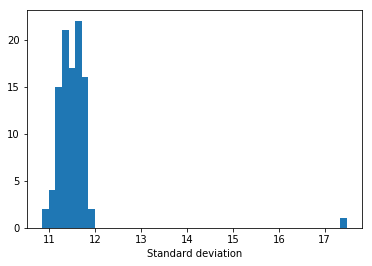

In [67]:
plt.hist(hist_rel_err_mean_std(gg_2,sim_gains_amp_2)[0],'auto') 
plt.xlabel('Standard deviation')
#plt.savefig('std_hist_corrcal_5by5_nogainfluc_Tsys_50_no_dish_scatter_initguess_1e-4')
plt.show()

In [68]:
#np.save('gg_corrcal_5by5_nogainfluc_Tsys_50_no_dish_scatter_initguess_1e-4', gg_2)
#np.save('sim_gains_corrcal_5by5_nogainfluc_Tsys_50_no_dish_scatter_initguess_1e-4', sim_gains_amp_2)